# Inferencia Resnet50

## Preparando Ambiente

In [1]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 35.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
import keras_cv

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

#from utils import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! cp "drive/MyDrive/Colab Notebooks/trabalho_final/explicabilidade/Dataset.zip" .

In [5]:
! cp "drive/MyDrive/Colab Notebooks/trabalho_final/explicabilidade/test.csv" .
! cp "drive/MyDrive/Colab Notebooks/trabalho_final/explicabilidade/train.csv" .

In [6]:
! unzip -q Dataset.zip

In [7]:
! mv Train/normal Train/0
! mv Train/cancer Train/1
! mv Validation/normal Validation/0
! mv Validation/cancer Validation/1
! mv Test/normal Test/0
! mv Test/cancer Test/1

In [8]:
train_dir_path = "./Train"
val_dir_path="./Validation"
test_dir_path="./Test"

img_height = 512
img_width = 256

In [12]:
class_names = ['normal', 'cancer']

train_generator = tf.keras.utils.image_dataset_from_directory(
        train_dir_path,
        image_size = (img_height, img_width),
        batch_size = 64,
        label_mode = "binary")
validation_generator = tf.keras.utils.image_dataset_from_directory(
        val_dir_path,
        image_size = (img_height, img_width),
        batch_size = 64,
        label_mode = "binary")
test_generator = tf.keras.utils.image_dataset_from_directory(
        test_dir_path,
        image_size = (img_height, img_width),
        batch_size = 64,
        label_mode = "binary")

Found 34995 files belonging to 2 classes.
Found 8749 files belonging to 2 classes.
Found 10962 files belonging to 2 classes.


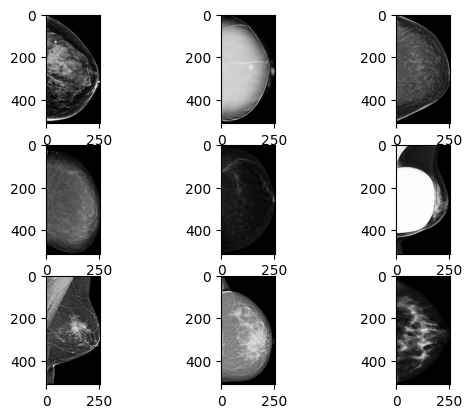

In [13]:

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in validation_generator:
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        # print(X_batch[i])
        plt.imshow(X_batch[i].numpy().astype("uint8"))
    # show the plot
    plt.show()
    break

## Carregando Modelo

In [18]:
model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (512, 256, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False

# build the entire model
input = tf.keras.layers.Input([img_height, img_width, 3])
x = keras_cv.layers.AutoContrast((0, 255))(input)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = model_resnet50(x)
x = GlobalAveragePooling2D()(x)
model = Model(inputs = [input], outputs = [x])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512, 256, 3)]     0         
                                                                 
 auto_contrast_3 (AutoContra  (None, 512, 256, 3)      0         
 st)                                                             
                                                                 
 tf.__operators__.getitem_3   (None, 512, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 512, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 16, 8, 2048)       23587712  
                                                           

## Realizando Inferencia

In [31]:
predictions = model.predict(test_generator, verbose=1)

172/172 [==============================] - 79s 448ms/step


In [32]:
len(predictions)

10962

In [33]:
datadict = {
    'features': [],
    'filepath': [],
}
for path, feature in zip(test_generator.file_paths, predictions):
  datadict["filepath"].append(path)
  datadict["features"].append(feature)


In [34]:
datadict["features"][0]

array([0.14649168, 0.6982671 , 0.0059967 , ..., 0.5927348 , 0.36774433,
       1.2671118 ], dtype=float32)

In [35]:
import pandas as pd
set_features = pd.DataFrame(datadict)

In [36]:
set_features.to_json("features_test_hist.json")

In [37]:
! cp features_validation_hist.json "drive/MyDrive/Colab Notebooks/trabalho_final/explicabilidade/"

In [38]:
! cp features_test_hist.json "drive/MyDrive/Colab Notebooks/trabalho_final/explicabilidade/"

In [39]:
! cp features_train_hist.json "drive/MyDrive/Colab Notebooks/trabalho_final/explicabilidade/"